In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA


In [5]:
df = pd.read_csv("online_shoppers_intention.csv")
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
print("Initial missing values per column:")
missing_cols = df.isnull().sum()
print(missing_cols[missing_cols > 0])

Initial missing values per column:
Series([], dtype: int64)


In [9]:
# Numeric Columns → Fill with Mean
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_imputer = SimpleImputer(strategy="mean")
df[numeric_cols] = pd.DataFrame(
    num_imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# Object Columns → Fill with Most Frequent
object_cols = df.select_dtypes(include=["object"]).columns
cat_imputer = SimpleImputer(strategy="most_frequent")
df[object_cols] = pd.DataFrame(
    cat_imputer.fit_transform(df[object_cols]),
    columns=object_cols
)

In [11]:
df["Weekend"] = df["Weekend"].astype(int)
df["Revenue"] = df["Revenue"].astype(int)

In [13]:
le_visitor = LabelEncoder()
df["VisitorType"] = le_visitor.fit_transform(df["VisitorType"])
print("VisitorType mapping:")
for cls, label in zip(le_visitor.classes_, le_visitor.transform(le_visitor.classes_)):
    print(f"{cls}: {label}")

VisitorType mapping:
New_Visitor: 0
Other: 1
Returning_Visitor: 2


In [15]:
df = pd.get_dummies(df, columns=["Month"], drop_first=True)

In [17]:
df["SessionDuration"] = (
    df["Administrative_Duration"] +
    df["Informational_Duration"] +
    df["ProductRelated_Duration"]
)

In [ ]:
Final Missing Value Check

In [7]:
print("Final Missing Value Check:")
total_missing = df.isnull().sum().sum()
print(f"Total missing values in DataFrame: {total_missing}")

Final Missing Value Check:
Total missing values in DataFrame: 0


In [33]:
# Classification 1: Purchase Prediction (Target: Revenue)
x1 = df.drop("Revenue", axis=1)
y1 = df["Revenue"]
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
model1 = RandomForestClassifier()
model1.fit(x1_train, y1_train)
y1_pred = model1.predict(x1_test)
print("\nPurchase Prediction Report:")
print(classification_report(y1_test, y1_pred))


Purchase Prediction Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2055
           1       0.97      0.89      0.92       411

    accuracy                           0.98      2466
   macro avg       0.97      0.94      0.95      2466
weighted avg       0.98      0.98      0.98      2466



In [35]:
# Classification 2: Predicting Visitor Type (Target: VisitorType)
x2 = df.drop("VisitorType", axis=1)
y2 = df["VisitorType"]
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)
model2 = RandomForestClassifier()
model2.fit(x2_train, y2_train)
y2_pred = model2.predict(x2_test)
print("\nVisitor Type Prediction Report:")
print(classification_report(y2_test, y2_pred))


Visitor Type Prediction Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       344
           1       1.00      0.50      0.67        10
           2       0.98      1.00      0.99      2112

    accuracy                           0.98      2466
   macro avg       0.99      0.80      0.87      2466
weighted avg       0.98      0.98      0.98      2466



In [37]:
# Classification 3: Predict Session Time Bucket
def categorize_session(duration):
    if duration < 300:
        return 0  # Short
    elif 300 <= duration < 1000:
        return 1  # Medium
    else:
        return 2  # Long

df["SessionBucket"] = df["SessionDuration"].apply(categorize_session)
x3 = df.drop(["SessionBucket"], axis=1)
y3 = df["SessionBucket"]
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.2, random_state=42)
model3 = RandomForestClassifier()
model3.fit(x3_train, y3_train)
y3_pred = model3.predict(x3_test)
print("\nSession Time Bucket Prediction Report:")
print(classification_report(y3_test, y3_pred))


Session Time Bucket Prediction Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       770
           1       1.00      1.00      1.00       768
           2       1.00      1.00      1.00       928

    accuracy                           1.00      2466
   macro avg       1.00      1.00      1.00      2466
weighted avg       1.00      1.00      1.00      2466



In [29]:
# Standardizing data for clustering
features_for_clustering = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_for_clustering)

# DBSCAN Clustering
dbscan = DBSCAN(eps=2, min_samples=5)  # You can tune eps/min_samples
df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)

print("\nDBSCAN Cluster Distribution:")
print(df['DBSCAN_Cluster'].value_counts())


DBSCAN Cluster Distribution:
DBSCAN_Cluster
 0     7352
 1     1797
-1     1494
 6      731
 7      246
 8      234
 2      155
 3       97
 9       78
 17      27
 4       16
 11      15
 16      12
 10      10
 12       8
 22       8
 14       7
 21       7
 13       6
 23       6
 20       6
 5        6
 18       6
 15       4
 19       2
Name: count, dtype: int64


In [39]:
# Clustering Task 1: User Segmentation
features_seg = df[["BounceRates", "ExitRates", "PageValues", "SpecialDay", "SessionDuration"]]
scaler = StandardScaler()
features_seg_scaled = scaler.fit_transform(features_seg)
kmeans1 = KMeans(n_clusters=3, random_state=42)
kmeans1_labels = kmeans1.fit_predict(features_seg_scaled)
df["UserSegment"] = kmeans1_labels
print("\nUser Segmentation Completed - Cluster Labels added")


User Segmentation Completed - Cluster Labels added


In [41]:
# Clustering Task 2: Behavioral Clustering
features_behav = df[["Administrative", "Informational", "ProductRelated", "SessionDuration"]]
features_behav_scaled = scaler.fit_transform(features_behav)
kmeans2 = KMeans(n_clusters=3, random_state=42)
kmeans2_labels = kmeans2.fit_predict(features_behav_scaled)
df["BehaviorCluster"] = kmeans2_labels
print("Behavioral Clustering Completed - Cluster Labels added")

Behavioral Clustering Completed - Cluster Labels added


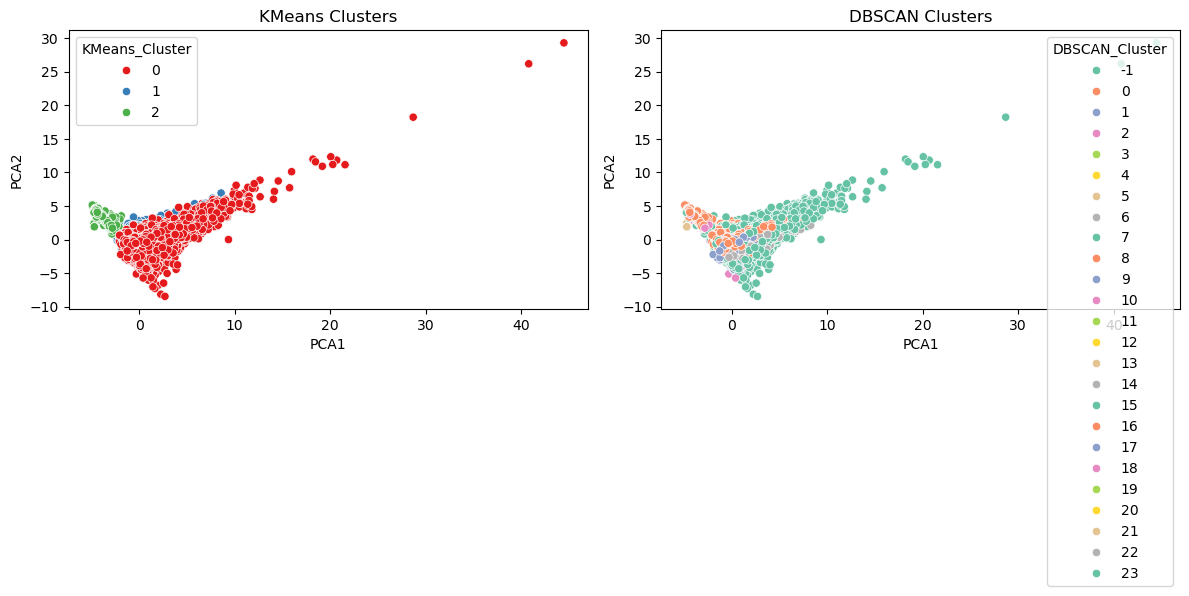

In [43]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)
df['PCA1'] = reduced[:, 0]
df['PCA2'] = reduced[:, 1]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1')
plt.title("KMeans Clusters")

# DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2')
plt.title("DBSCAN Clusters")

plt.tight_layout()
plt.show()